
<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## Deep Learning for Time Series Forecasting

### Eduardo Maldonado Cruz, Graduate Research Assistant, The University of Texas at Austin

#### [Twitter](https://twitter.com/emaldonadocruz) | [GitHub](https://github.com/emaldonadocruz) | [LinkedIn](https://www.linkedin.com/in/eduardo-maldonado-8386a898/)

### Michael Pyrcz, Associate Professor, The University of Texas at Austin 

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

## Executive summary

Forecasting fluid flow is essential to support optimum development decisions of subsurface resources such as groundwater, geothermal, and oil and gas. Forecasting offers invaluable information for understanding reservoirs, improving well productivity, preparing development and adjustment programs to maximize well ultimate recovery, recoverable reserves, and overall maximize project economics. In this workflow we explore a unique dataset containing gas production of multiple wells with no petrophysical information. We use LSTM recurrent neural network(RNN) architecture to forecast gas flow for a given production history interval. The derived model is used to forecast 12 months of gas production. We compare the forecast with the historical gas production.

## Introduction

Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture. The purpose of RNN is to process sequence of data, where the current output of a sequence is related to the previous output. Unlike standard feedforward neural networks, LSTM has feedback connections.

A single layer network is composed of the input x, and the output y is transformed by transforming $Wx+b$ and activated by the function $f$ :

\begin{equation*}
y=f\left(Wx+b\right)
\label{eq:NN} \tag{1}
\end{equation*}

A common LSTM unit is composed of a cell, an input gate, an output gate and a forgetten gate. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell.

1 Forget Gate

\begin{equation*}
f_{t}=\sigma\left(w_{f}^{T}\ast h_{t-1}+U_{f}^{T}\ast x_{t}+b_{f}\right)
\label{eq:Forg} \tag{2}
\end{equation*}

2 Input Gate

\begin{equation*}
i_{t}=\sigma\left(w_{i}^{T}\ast h_{t-1}+U_{i}^{T}\ast x_{t}+b_{i}\right)
\label{eq:Inp} \tag{3}
\end{equation*}

3 Candidate Gate

\begin{equation*}
c_{t}=\sigma\left(w_{c}^{T}\ast h_{t-1}+U_{c}^{T}\ast x_{t}+b_{c}\right)
\label{eq:Cand} \tag{4}
\end{equation*}

4 Output Gate

\begin{equation*}
O_{t}=\sigma\left(w_{o}^{T}\ast h_{t-1}+U_{o}^{T}\ast x_{t}+b_{o}\right)
\label{eq:Out} \tag{5}
\end{equation*}

\begin{equation*}
h_t= O_{t}\ast tanh \left(C_{t}\right)
\end{equation*}

<div>
<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png" width="400"/>
</div>

<div>
<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM2-notation.png" width="400"/>
</div>


(Figure source: Olah Christopher, "Long Short Term Memory". *Colah.Github.io*, August 27, 2015. [colah.github.io](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)) )

The main difference in training an LSTM in contrast to a MLP is that to predict a value pt at time $t$, the previous $n$ samples $\left\{ p_{t-n},...,p_{t-1}\right\} $ have to be propagated through the network. LSTMs are well-suited for making predictions based on time series data.

## Description

We use an LSTM for multi-step time series forecasting problem. For this specific problem we use a **Vector Output Model**

But first let's import some useful packages for data visualization, plotting and data analysis.

## Package importing

In [3]:
#Plotting
import matplotlib.pyplot as plt

# Data analysis
import pandas as pd
import numpy as np
from numpy import array

#Error measurement metrics
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import StandardScaler

## Pytorch libraries to define the LSTM
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 

from torch.optim.lr_scheduler import ReduceLROnPlateau

#Import partial autocorrelation plot
from statsmodels.graphics.tsaplots import plot_pacf

#Import UTuning
from UTuning import scorer, plots

# Module to fit gaussian mixtures
from sklearn import mixture

import random

In [4]:
#Set seed numbers for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [5]:
## We load a custom figure style
plt.style.use('https://raw.githubusercontent.com/emaldonadocruz/Publication_figure_style/master/Publication_figure_style.mplstyle')

Next we define a couple of useful functions that will be used in the notebook

In [6]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

def time_array(array):
    """
    Returns a time array in months
    """
    time=np.arange(0,len(array),1)
    return time

def plot_loss(history):
    plt.figure(figsize=(12,6))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    #plt.plot(history.history['val_loss'], label='val_loss')
    #plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [Production]')
    plt.legend()
    plt.grid(True)    


In [7]:
def to_tensor(arr):
    tensor_array=Variable(torch.Tensor(arr))
    return tensor_array

def reshape(tensor):
    return torch.reshape(tensor,  (tensor.shape[0], 1, tensor.shape[1])) 

def to_numpy(tensor_array):
    return tensor_array.data.numpy()

In [8]:
def return_ensemble(n_cases,X_test):
    ensemble = np.zeros([cases,X_test.shape[0]])
    for i in range(n_cases):
    
        test_predict = lstm1(X_test)#forward pass
        #data_predict = test_predict.data.numpy() #numpy conversion
        
        ensemble[i,:]= to_numpy(test_predict[:,0])
        
    return ensemble

In [9]:
## Next step

def return_step(time,difference,window):
    array = np.zeros([1,3])
    array[0,0] = time
    array[0,1] = difference
    array[0,2] = window
    return array

In [10]:
def generate_ensemble(step):
    #X_test_tensors = to_tensor(X_test_step_p50)#Variable(torch.Tensor(X_test))
    X_test_tensor = reshape(to_tensor(step))#torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 
    return return_ensemble(50,X_test_tensor)


In [11]:
def return_percentiles(arr):
    return np.percentile(arr,10),np.percentile(arr,50),np.percentile(arr,90)

## Production data

### Load data:

The following workflow uses a .csv file that contains:
* Entire production data for all wells at different times in months, Production data is in Mscf, time is in months

In [13]:
df= pd.read_csv('Field_rate.csv')

Rate=df.loc[:,df.columns.str.startswith('Well')].to_numpy()
Rate=np.nan_to_num(Rate)

name_wells=[0]

def well_picker(arr,listw):
    list_wells=[]
    list_times = []
    for i in range(len(listw)):
        list_wells.append(arr[:,listw[i]])
        list_times.append(np.arange(0,np.count_nonzero(arr[:,listw[i]])))
    return list_wells,list_times

Wells,Times = well_picker(Rate,name_wells)

dataset = np.hstack(Wells)
Time = np.hstack(Times)
dataset = dataset[dataset!=0]


In [14]:
#Construc a dataframe that contains information of production and time
data = pd.DataFrame({'Production':dataset,'Time':Time})

### Partial autocorrelation plot

Time series of data are correlated in time. We have autocorrelation! 𝑡+1 is close to the value at time 𝑡. Autocorrelation is the measure of the degree of similarity between a given time series and the lagged version of that time series over successive time periods.
The plot of the autocorrelation function describes he direct relationship between an observation and its lag.

Text(0.5, 0, 'Time steps')

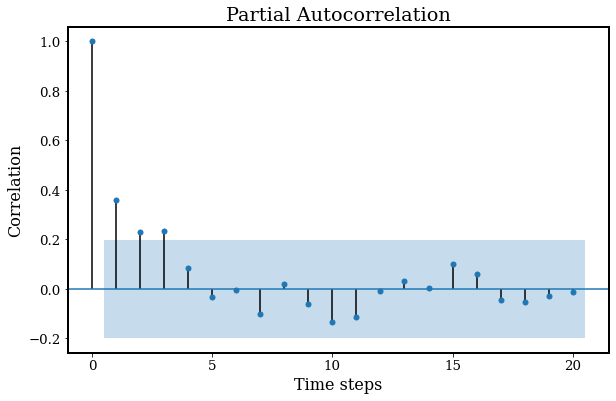

In [15]:
plot_pacf(data.Production.diff(1).dropna(),method = 'ywm')
plt.ylabel('Correlation')
plt.xlabel('Time steps')

## Standarization and scaling

In [16]:
#Perform standarization and scaling
scaler_prod = StandardScaler()
scaler_time = StandardScaler()
prod_data = scaler_prod.fit_transform(data.Production.values.reshape(-1,1))
time_data = scaler_time.fit_transform(data.Time.values.reshape(-1,1))

In [17]:
data = pd.DataFrame({'Production':prod_data[:,0],'Time':time_data[:,0]})

data['Difference'] = data['Production'].diff(1).shift(1)
data['Rwindow'] = data['Production'].rolling(window=2).mean().shift(1)


data = data.iloc[4:] ## We remove the first 4 points and shift the data to avoid autocorrelation
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 4 to 98
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Production  95 non-null     float64
 1   Time        95 non-null     float64
 2   Difference  95 non-null     float64
 3   Rwindow     95 non-null     float64
dtypes: float64(4)
memory usage: 3.1 KB


In [18]:
X = np.zeros([len(data.index),3]) #Features: Time, Difference, Rate
y = np.zeros([len(data.index),1])

In [19]:
X[:,0] = data.Time.values
X[:,1] = data.Difference.values
X[:,2] = data.Rwindow.values

y = data.Production.values

And select a number of steps from the time series and a well from the production data.

## Data example

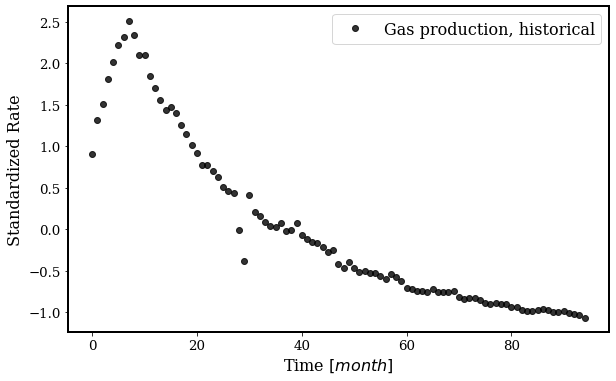

In [20]:
fig, ax = plt.subplots()

ax.plot(y,'ko',alpha=0.8,label='Gas production, historical');
ax.set_ylabel('Standardized Rate')
ax.set_xlabel('Time $[month]$')
ax.legend();

The rate difference is plotted next

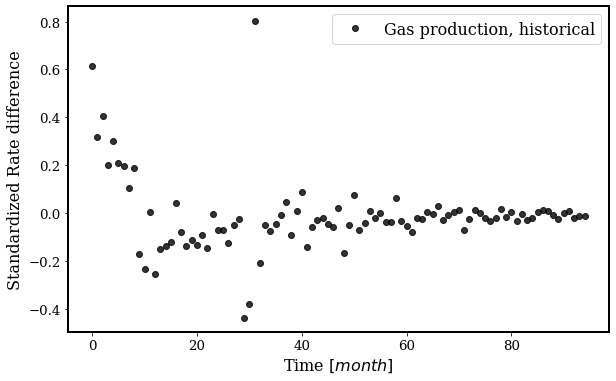

In [21]:
fig, ax = plt.subplots()

ax.plot(X[:,1],'ko',alpha=0.8,label='Gas production, historical');
ax.set_ylabel('Standardized Rate difference')
ax.set_xlabel('Time $[month]$')
ax.legend();

## Data serparation between training and testing

We want to predict the next 20 months from our dataset. This corresponds to about 20% of testing

In [22]:
n_features=1
train= len(data.index)-20
test = len(data.index) - train
X_train = X[:train,:]
X_test= X[train:,:]
y_train = y[:train] 
y_test = y[train:]

y_train = y_train.reshape((y_train.shape[0]),1)
y_test = y_test.reshape((y_test.shape[0]),1)

Transformation to tensors

In [23]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

And reshape

In [24]:
#reshaping to rows, timestamps, features

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

In [25]:
print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([75, 1, 3]) torch.Size([75, 1])
Testing Shape torch.Size([20, 1, 3]) torch.Size([20, 1])


### LSTM definition

Next we define the lstm, we include dropout as bayesian approximation

In [26]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length, p = 0.01):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 1024) #fully connected 1
        self.fc_2 =  nn.Linear(1024,1024) #fully connected 1
        self.fc_3 =  nn.Linear(64,32) #fully connected 1
        self.fc = nn.Linear(1024, num_classes) #fully connected last layer
        self.p = p
        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        #out = nn.functional.dropout(out, p=self.p, training=True)
        out = self.fc_1(out) #first Dense
        out = nn.functional.dropout(out, p=self.p, training=True)
        out = self.relu(out) #relu
        
        out = self.fc_2(out) #second Dense
        out = nn.functional.dropout(out, p=self.p, training=True)
        out = self.relu(out) #relu
                
        out = self.fc(out) #Final Output
        return out

We use the following model parameters that were previously found by hyperparameter search

In [27]:
num_epochs = 700 #1000 epochs
learning_rate = 0.001#0.001 #0.001 lr

input_size = 3 #number of features
hidden_size = 7*96#6 #number of features in hidden state #10, 9
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

dropout = 0.0

In [28]:
lstm1 = LSTM1(num_classes,
              input_size,
              hidden_size,
              num_layers,
              X_train_tensors_final.shape[1],
              p=dropout) #

In [29]:
print(lstm1)

LSTM1(
  (lstm): LSTM(3, 672, batch_first=True)
  (fc_1): Linear(in_features=672, out_features=1024, bias=True)
  (fc_2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc_3): Linear(in_features=64, out_features=32, bias=True)
  (fc): Linear(in_features=1024, out_features=1, bias=True)
  (relu): ReLU()
)


In [30]:
criterion = torch.nn.L1Loss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

Perform model training 

In [31]:
loss_values=[]
loss_test_values=[]
for epoch in range(num_epochs):
    outputs = lstm1.forward(X_train_tensors_final) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0

    # obtain the loss function
    loss = criterion(outputs, y_train_tensors)
    loss.backward() #calculates the loss of the loss function
    loss_values.append(loss.item())

    
    test_output = lstm1.forward(X_test_tensors_final) #forward pass
    loss_test = criterion(test_output, y_test_tensors)
    #scheduler.step(loss_test)
    loss_test_values.append(loss_test.item())

    optimizer.step() #improve from loss, i.e backprop
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
        print(f'Epoch: {epoch:3.0f}, MAE: {loss.item()}')
        


Epoch: 0, loss: 0.80252
Epoch:   0, MAE: 0.8025223612785339
Epoch: 100, loss: 0.05054
Epoch: 100, MAE: 0.05053795501589775
Epoch: 200, loss: 0.05201
Epoch: 200, MAE: 0.052013665437698364
Epoch: 300, loss: 0.04458
Epoch: 300, MAE: 0.044581618160009384
Epoch: 400, loss: 0.03103
Epoch: 400, MAE: 0.03102775663137436
Epoch: 500, loss: 0.03847
Epoch: 500, MAE: 0.03846953809261322
Epoch: 600, loss: 0.02918
Epoch: 600, MAE: 0.029184166342020035


We make a curve to show the loss and evaluate if the model is underfitting or overfitting

Text(0, 0.5, 'Loss')

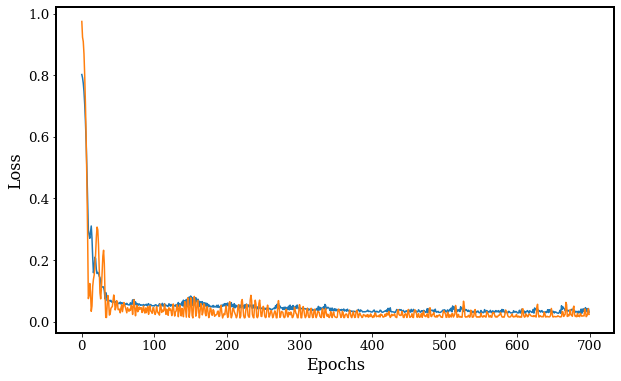

In [32]:
plt.figure(figsize=(10,6))
plt.plot(loss_values)
plt.plot(loss_test_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')

#### LSTM training and prediction data

Next we use the trained model to predict the training data and observe the fit

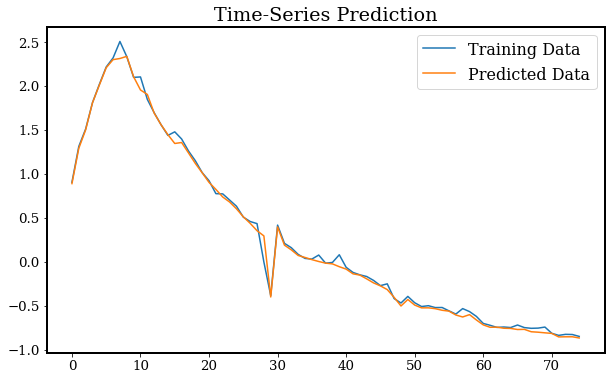

In [33]:
train_predict = lstm1(X_train_tensors_final)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = y_train[:,0]

plt.figure(figsize=(10,6)) #plotting
plt.plot(dataY_plot, label='Training Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
ax.set_ylabel('Standardized Rate')
ax.set_xlabel('Time $[month]$')
plt.legend()
plt.show() 

There is no shift in our predictions, the model is truly learning from the dataset. Next comes forecasting.

#### Forecasting

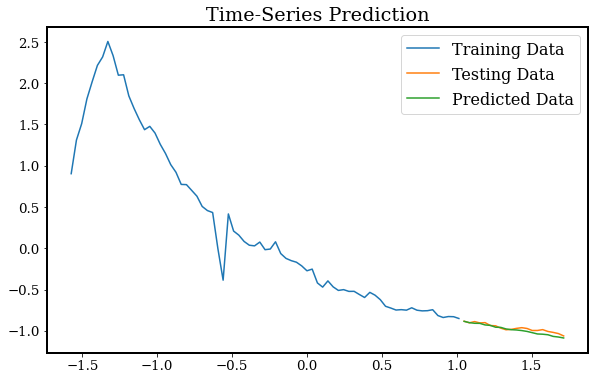

In [34]:
test_predict = lstm1(X_test_tensors_final)#forward pass
test_pred = test_predict.data.numpy() #numpy conversion

plt.plot(X_train[:,0],y_train,label = 'Training Data')
plt.plot(X_test[:,0],y_test[:,0], label='Testing Data') #actual plot
plt.plot(X_test[:,0],test_pred[:,0], label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
ax.set_ylabel('Standardized Rate')
ax.set_xlabel('Time $[month]$')
plt.legend()
plt.show() 

## The Authors:

### Eduardo Maldonado Cruz, Graduate Research Assistant, The University of Texas at Austin

#### [Twitter](https://twitter.com/emaldonadocruz) | [GitHub](https://github.com/emaldonadocruz) | [LinkedIn](https://www.linkedin.com/in/eduardo-maldonado-8386a898/)

Eduardo is a Ph.D. in Petroleum Engineering candidate at the University of Texas at Austin in the Hildebrand Department of Petroleum and Geosystems Engineering. Before that, he worked as a lecturer and Reservoir Engineer for a private company in Mexico, where he developed multiple development projects in tight gas. He received his Bachelor’s and Master’s degree from the National Autonomous University of Mexico. Eduardo’s specializations include reservoir engineering, numerical simulation, machine learning, and uncertainty modeling.

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin

I have other demonstrations on the basics of working with DataFrames, ndarrays, univariate statistics, plotting data, declustering, data transformations, trend modeling and many other workflows available at https://github.com/GeostatsGuy/PythonNumericalDemos and https://github.com/GeostatsGuy/GeostatsPy. 
  
I hope this was helpful,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)
